# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset


# Install detectron2

In [1]:
# Some basic setup:
# Setup detectron2 logger

from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os,cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [16]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
!curl http://images.cocodataset.org/val2017/000000439715.jpg -s -o input.jpg

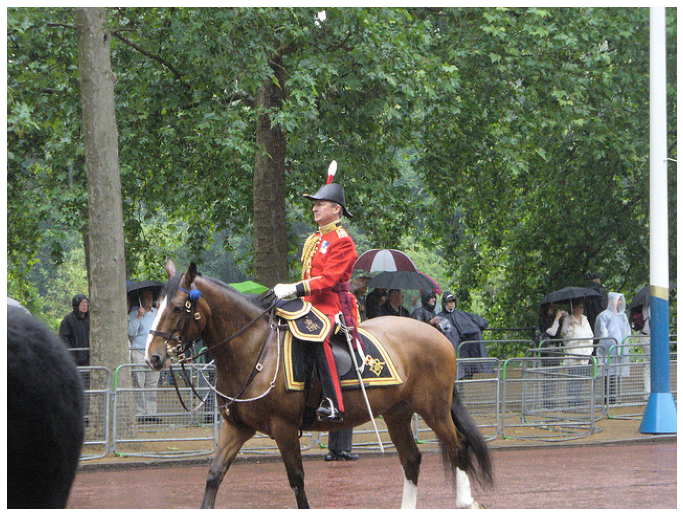

In [17]:
im = cv2.imread("./input.jpg")
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im[:,:,::-1])

In [18]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [19]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.5957, 244.9040, 459.8316, 480.0000],
        [251.1053, 157.8070, 338.9749, 413.6352],
        [114.8518, 268.6918, 148.2410, 398.8155],
        [  0.8212, 281.0345,  78.6053, 478.4239],
        [ 49.3947, 274.1225,  80.1540, 342.9835],
        [561.2248, 271.5823, 596.2776, 385.2583],
        [385.9070, 270.3120, 413.7124, 304.0393],
        [515.9364, 278.3741, 562.2789, 389.3763],
        [335.2333, 251.9164, 414.7515, 275.9361],
        [350.9403, 269.2105, 386.0952, 297.9070],
        [331.6305, 230.9982, 393.2782, 257.1976],
        [510.7337, 263.2697, 570.9878, 295.9326],
        [409.0876, 271.8618, 460.5584, 356.8657],
        [506.8834, 283.3279, 529.9495, 324.0209],
        [594.5674, 283.4854, 609.0563, 311.4102]], device='cuda:0'))


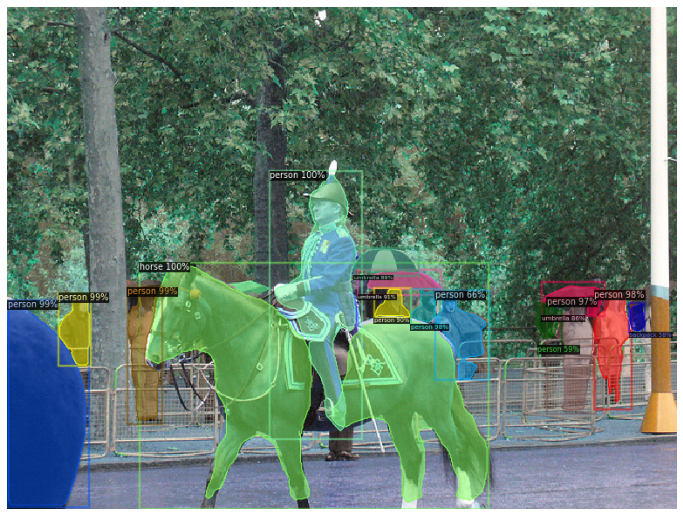

In [13]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset



## Prepare the dataset

In [6]:
!unzip augmented_good_test.zip -d  augmented_good_test/ > /dev/null

unzip:  cannot find or open augmented_good_test.zip, augmented_good_test.zip.zip or augmented_good_test.zip.ZIP.


In [ ]:
!unzip augmented_good_train.zip -d  augmented_good_train/ > /dev/null

In [7]:
!unzip augmented_bad_test.zip -d  augmented_bad_test/ > /dev/null

In [9]:
!unzip augmented_bad_train.zip -d  augmented_bad_train/ > /dev/null

In [31]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bad_train", {}, "../dataset/train/annotations/instances_default.json", "../dataset/train/images")
register_coco_instances("bad_test", {}, "../dataset/train/annotations/instances_default.json", "../dataset/train/images")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



[04/25 15:28:02 d2.data.datasets.coco]: Loaded 58 images in COCO format from ../dataset/train/annotations/instances_default.json


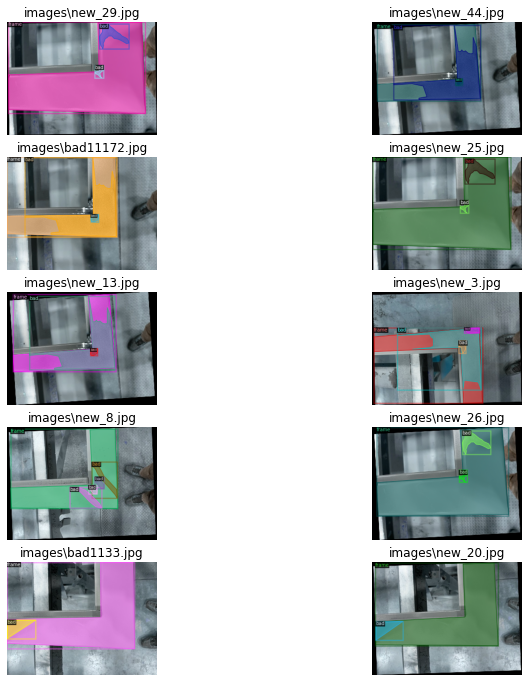

In [34]:
dataset_dicts = DatasetCatalog.get("bad_train")
fig,axes=plt.subplots(5,2,figsize=(12,12))

for (i,ax),d in zip(enumerate(axes.flat),random.sample(dataset_dicts,10)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("bad_train"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(d["file_name"].split("/")[-1])
    ax.axis("off")
plt.show()

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("train",)
# cfg.DATASETS.TEST = ("test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [8]:
#download cfg
with open("D:/Yottaasys/assa_abloy/Assa-Abloy/detectron2/configs/mask_rcnn_R_50_FPN_3x.yaml", "w") as f:
  f.write(cfg.dump()) 

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [37]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

[04/25 15:36:02 d2.data.datasets.coco]: Loaded 58 images in COCO format from ../dataset/train/annotations/instances_default.json


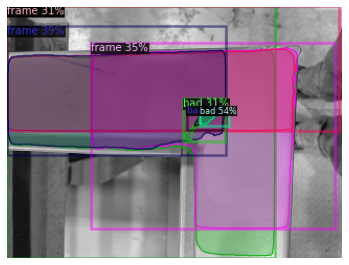

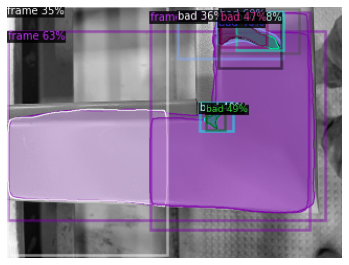

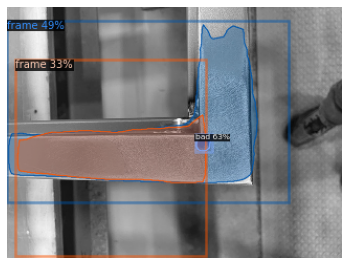

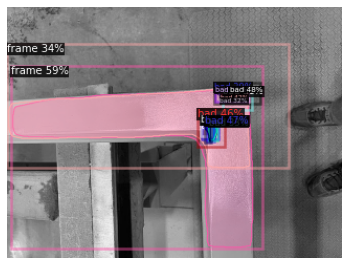

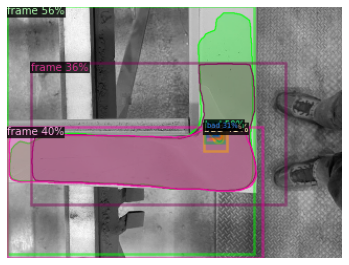

In [38]:
from detectron2.utils.visualizer import ColorMode
import cv2
dataset_dicts = DatasetCatalog.get("bad_test")
for d in dataset_dicts[:5]:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("bad_test"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [39]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bad_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "bad_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/25 15:36:55 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[04/25 15:36:55 d2.data.datasets.coco]: Loaded 58 images in COCO format from ../dataset/train/annotations/instances_default.json
[04/25 15:36:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 15:36:55 d2.data.common]: Serializing 58 elements to byte tensors and concatenating them all ...
[04/25 15:36:55 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/25 15:36:55 d2.evaluation.evaluator]: Start inference on 58 batches
[04/25 15:36:59 d2.evaluation.evaluator]: Inference done 11/58. Dataloading: 0.0005 s/iter. Inference: 0.1290 s/iter. Eval: 0.0029 s/iter. Total: 0.1324 s/iter. ETA=0:00:06
[04/25 15:37:04 d2.evaluation.evaluator]: Inference done 49/58. Dataloading: 0.0006 s/iter. Inference: 0.1292 s/iter. Eval: 0.0037 s/iter. Total: 0.1335 s/iter. ET